# Advanced Machine Learning - programming assignment 3

*Due: Friday January 12*

*Grading: 10 points total*

**Please fill in:**
* Ingólfur Ari Jóhannsson (2431475)
* Nikos Lazaridis (7496974)

### Further instructions:
* Code quality is considered during the assessment. Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [105]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

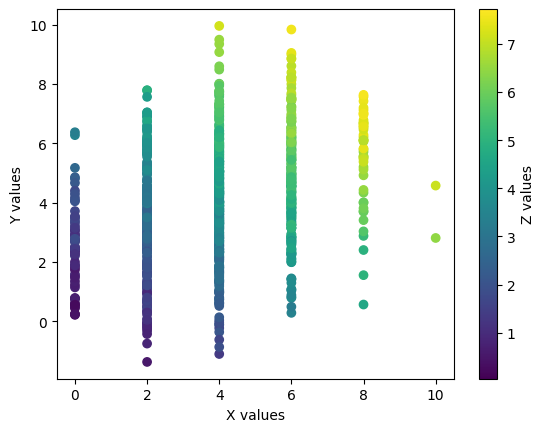

In [106]:
scatter = plt.scatter(x, y, c=z)
plt.colorbar(scatter,label="Z values")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.show()

**Task 1 (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

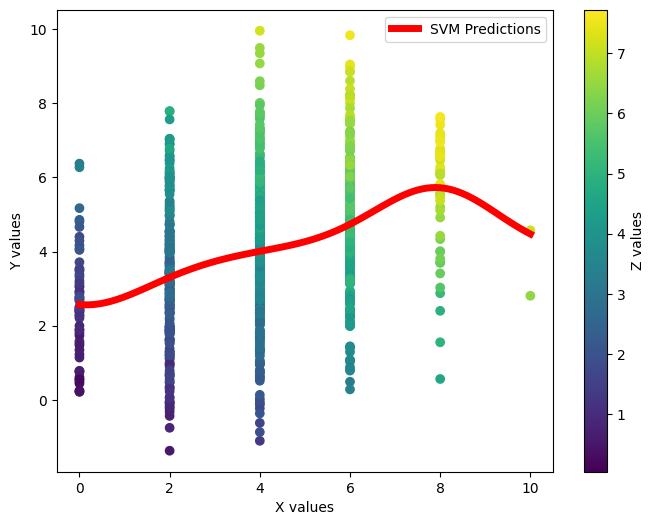

In [107]:
from sklearn.svm import SVR

# Create and fit SVM model
svm_model = SVR()
svm_model.fit(x.reshape(-1,1), y)

# Create a linspace from 0 to 10 with step 0.1
x_values = np.linspace(min(x), max(x), num=101)

X_pred = x_values.reshape(-1, 1)

# Predict using the SVM model
predictions = svm_model.predict(X_pred)

# Scatter plot of the linspace values
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=z)
plt.colorbar(scatter,label="Z values")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.plot(x_values, predictions, label='SVM Predictions', color='red',linewidth=5)
plt.legend()
plt.show()


In [108]:
def calculate_rmse(model, x, y):
    """
    Calculate Root Mean Squared Error (RMSE) for a given model and input data.

    Parameters:
    - model: The predictive model with a `predict` method.
    - x: Input data (list or numpy array).
    - y: True labels (list or numpy array).

    Returns:
    - rmse: Root Mean Squared Error.
    """
    predictions = [model.predict(np.array(x_val).reshape(-1, 1)) for x_val in x]
    rmse = np.sqrt(np.mean([(prediction - label) ** 2 for prediction, label in zip(predictions, y)]))
    return rmse
calculate_rmse(model=svm_model,x=x,y=y)

1.8510909495219892

Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question 2 (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.

The relevant genetic information variable does not have any direct cause from the other endogenous variables, the treatment has a direct cause from relevant genetic information and outcome has a direct cause from both relevant genetic information and treatment. These relations make sense in the physical world since Z (i.e. genetic profile of the patient) is something that cannot be affected/changed from the dosage or the outcome of a treatment. Subsequently, the dosage of a treatment is considered based on the genetic profile of a patient, such as gender, age, or medical history. Finally, the outcome of a treatment is affected from both the dosage of the treatment and the genetic profile of the patient.

## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task 3 (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [109]:
def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X=x[i]). x is a vector of length num_samples.
    z = f_Z(num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [110]:
num_samples_exp = 200

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
x_exp = x_exp.reshape(-1,1).flatten()
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

**Task 4 (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

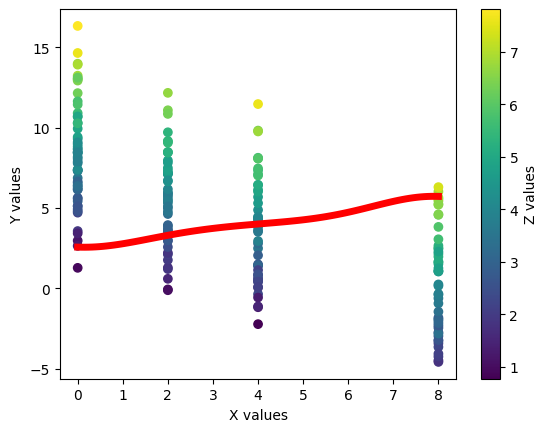

In [111]:
# Your code here
scatter = plt.scatter(x_exp, y_exp, c=z_exp)
x_values = np.linspace(min(x_exp), max(x_exp), num=101)
predictions = svm_model.predict(x_values.reshape(-1,1))
plt.plot(x_values, predictions, label='SVM Predictions', color='red', linewidth=5)
plt.colorbar(scatter,label="Z values")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.show()

**Task 5 (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [112]:
calculate_rmse(model=svm_model,x=x_exp,y=y_exp)

5.285661764470899

You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question 6 (1 point):** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution? And what conditional distribution (which may or may not appear in either product decomposition) needs to stay the same between the two distributions, in order for your fitted curve to also give good predictions on the experimental data?

The product decompositions of the original SCM and the modified SCM look like: P~org~ = P(Z=z)P(X=x|Z=z)P(Y=y|X=x,Z=z) and P~mod~ = P(Z=z)P(X=x)P(Y=y|Z=z,X=x) respectively. The factors that look similar between the two distributions are P(Z=z) and P(Y=y|Z=z,X=x), although the distribution P(X=x) on which P(Y=y) is conditioned, has been altered with the given intervention.


**Question 7 (1.5 points):** What (marginal or conditional) independence should hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

In the experimental data, X and Z collide to Y. Hence, based on d-separation:
- X and Y are likely dependent,
- Z and Y are likely dependent, 
- X and Z are independent,
- X and Z are likely dependent given Y.

By plotting the X against Z, we observe the predicted independence of the two variables by noticing that each value of X has a correspondence in each value of Z without any particular relationship being clear.

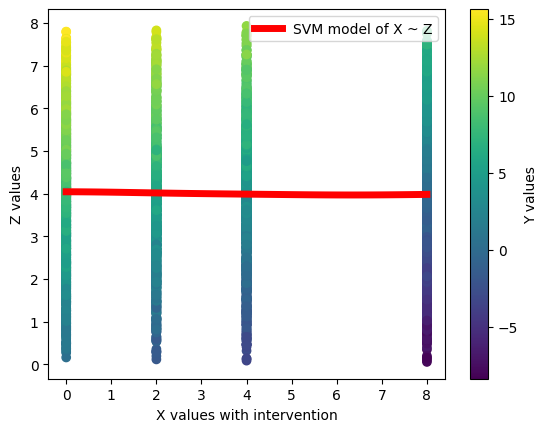

In [117]:
num_samples_exp = 5000

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

scatter = plt.scatter(x_exp, z_exp, c=y_exp)
plt.colorbar(scatter,label="Y values")
plt.xlabel("X values with intervention")
plt.ylabel("Z values")

# we train a new model just to showcase that the relationship between the values is flat
svm_model_flat = SVR()
svm_model_flat.fit(x_exp.reshape(-1,1), z_exp)
# Create a linspace from 0 to 10 with step 0.1
x_values = np.linspace(min(x_exp), max(x_exp), num=101)
X_pred_flat = x_values.reshape(-1, 1)
# Predict using the SVM model
predictions_flat = svm_model_flat.predict(X_pred)
plt.plot(x_values,predictions_flat,color="red",linewidth=5,label="SVM model of X ~ Z")
plt.legend()
plt.show()

**Task 8 (2 points):** Now, we will use the method of inverse probability weighing (section 3.6 in the book, covered in lecture 12) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract an estimate of $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

In [114]:
# Create logistic regression object (using scikit-learn)
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

# Your code here
num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)
reg_logistic.fit(z.reshape(-1, 1), x)

# Estimate probabilities for each data point
probabilities = reg_logistic.predict_proba(z.reshape(-1, 1)) 

sel_prob = []
for index, x_i in enumerate(x):
    sel_prob.append(probabilities[index][int(x_i/2)])
# Calculate inverse probability weights
inverse_probability_weights = 1 / np.array(sel_prob)

**Task 9 (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weigh each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

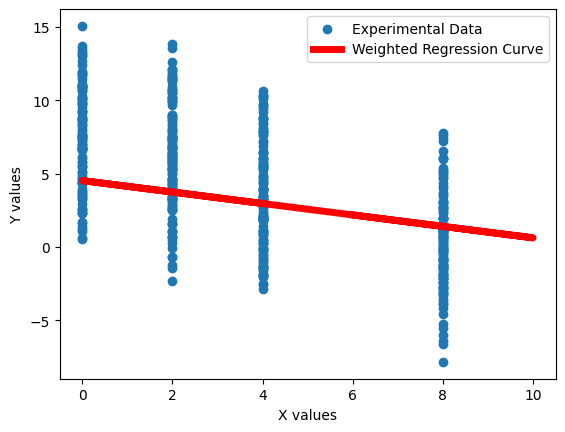

In [115]:
# Your code here
weight_reg_linear = linear_model.LinearRegression()
weight_reg_linear.fit(x.reshape(-1, 1), y, sample_weight=inverse_probability_weights)

# Predict Y values using the weighted regression model
predicted_Y = weight_reg_linear.predict(x.reshape(-1, 1))

# Plotting experimental data
plt.scatter(x_exp, y_exp, label='Experimental Data')

# Plotting regression curve
plt.plot(x, predicted_Y, color='red', label='Weighted Regression Curve',linewidth=5)

plt.colorbar(scatter,label="Y values")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend()
plt.show()

**Task 10 (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [116]:
calculate_rmse(model=weight_reg_linear,x=x,y=y)

2.6266601240277865

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).